[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Wp-Zhang/HandyRec/blob/master/examples/DIEN/DIEN.ipynb)

> This notebook runs DIEN on MovieLens1M dataset. We'll use YouTubeDNN for generating candidates and DIEN for ranking these candidates.

> Only movies with ratings larger than 3 are treated as 'positive' samples for each user. Every last 10 'positive' movies of each user are held out for testing.

## Table of Contents:
* [Prepare data for retrieval](#section-0)
* [Train retrieve model and export embeddings](#section-1)
* [Use Faiss to generate candidates](#section-2)
* [Train rank model and predict](#section-3)

**Download dataset and install packages**

In [1]:
! git clone https://github.com/Wp-Zhang/HandyRec.git
! cd HandyRec && python setup.py install
! pip install faiss-gpu

Cloning into 'HandyRec'...
remote: Enumerating objects: 1753, done.
remote: Counting objects: 100% (1753/1753), done.
remote: Compressing objects: 100% (1294/1294), done.
remote: Total 1753 (delta 717), reused 1345 (delta 407), pack-reused 0
Receiving objects: 100% (1753/1753), 20.93 MiB | 24.49 MiB/s, done.
Resolving deltas: 100% (717/717), done.
     |████████████████████████████████| 8.6 MB 4.2 MB/s 


In [2]:
! wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip
! unzip -o ml-1m.zip

--2022-04-16 05:32:40--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./ml-1m.zip’

./ml-1m.zip         100%[===================>]   5.64M  18.4MB/s    in 0.3s    

2022-04-16 05:32:40 (18.4 MB/s) - ‘./ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


**Import relative packages**

In [4]:
from handyrec.data.movielens import MovielensDataHelper
from handyrec.data.utils import gen_sequence
from handyrec.data import SequenceWiseDataset

from handyrec.models.ranking import DIEN
from handyrec.config import ConfigLoader
from handyrec.data.metrics import map_at_k, recall_at_k
from handyrec.models.utils import search_embedding

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import gc

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
BATCH_SIZE = 2**12
NEPOCH = 50

TEST_NUM = 10
VALID_RATIO = 0.1
NEG_NUM = 10

***Note:*** DIEN requires a SequenceWiseDataset dataset as input, which consumes much more memory than other types of datasets as it has both negative samples and negative sequences. If the notebook crashed, please consider lowering the values of `SEQ_LEN` and `NEG_NUM`.

**Load MovieLens1M data**

In [7]:
retrieve_dh = MovielensDataHelper('./ml-1m/')
data = retrieve_dh.get_clean_data(sparse_features=['gender','occupation','zip','age','year'])
data['inter']['hist_movie'] = gen_sequence(data['inter'], 'user_id', 'movie_id', seq_len=15)

Generate movie_id sequence: 100%|██████████| 6040/6040 [00:04<00:00, 1291.04it/s]


## Prepare data for ranking

In [ ]:
# * Use pre-trained embeddings and Faiss to generate candidates
user_embs = np.load("./HandyRec/examples/DSSM/DSSM_user_embd.npy")
item_embs = np.load("./HandyRec/examples/DSSM/DSSM_item_embd.npy")
user_ids = np.load("./HandyRec/examples/DSSM/user_ids.npy")

test_candidates = search_embedding(
    32, item_embs, user_embs, data["item"]["movie_id"].values, 100, gpu=True
)

test_candidates = {user_ids[i] : test_candidates[i] for i in range(len(user_ids))}

In [26]:
user_features = ['user_id', 'gender', 'occupation']
item_features = ['movie_id', 'genres']
inter_features = ['hist_movie']

In [27]:
ranking_dataset = SequenceWiseDataset(
    "RankingDataset",
    task="ranking",
    data=data,
    uid_name="user_id",
    iid_name="movie_id",
    inter_name="interact",
    time_name="timestamp",
    label_name="label",
    seq_name="hist_movie",
    neg_seq_name="neg_hist_movie",
    threshold=4,
)

ranking_dataset.train_test_split(TEST_NUM)
ranking_dataset.negative_sampling(NEG_NUM)
ranking_dataset.train_valid_split(VALID_RATIO)
ranking_dataset.gen_dataset(user_features, item_features, inter_features, test_candidates)

Save inter features: 100%|██████████| 2/2 [00:21<00:00, 10.95s/it]


In [28]:
train_data, valid_data, test_data, test_label = ranking_dataset.load_dataset(
    user_features, item_features, inter_features, BATCH_SIZE*2
)

Load inter features: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


In [29]:
feature_dim = ranking_dataset.get_feature_dim(user_features, item_features, [])
feature_dim["genre_id"] = 19

## Train rank model and predict <a name="section-3"></a>

In [30]:
cfg = ConfigLoader("./HandyRec/examples/DIEN/DIEN_cfg.yaml")
feature_groups = cfg.prepare_features(feature_dim, data)

In [33]:
rank_model = DIEN(
    feature_groups["item_seq_feat_group"],
    feature_groups["neg_item_seq_feat_group"],
    feature_groups["other_feature_group"],
    **cfg.config.Model
)

In [34]:
rank_model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-4, clipvalue=1.), loss=binary_crossentropy)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./rank_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
history = rank_model.fit(
    x=train_data, 
    validation_data=valid_data,
    epochs=NEPOCH,
    callbacks=[early_stop,checkpoint]
)

Epoch 1/50
623/623 [==============================] - 198s 296ms/step - loss: 132.9466 - val_loss: 77.3136
Epoch 2/50
623/623 [==============================] - 184s 295ms/step - loss: 56.8381 - val_loss: 39.9751
Epoch 3/50
623/623 [==============================] - 183s 293ms/step - loss: 33.0949 - val_loss: 27.4731
Epoch 4/50
623/623 [==============================] - 184s 295ms/step - loss: 24.0341 - val_loss: 20.4975
Epoch 5/50
623/623 [==============================] - 184s 295ms/step - loss: 18.0306 - val_loss: 15.8658
Epoch 6/50
623/623 [==============================] - 185s 296ms/step - loss: 13.3635 - val_loss: 10.0966
Epoch 7/50
623/623 [==============================] - 184s 295ms/step - loss: 8.5970 - val_loss: 6.9153
Epoch 8/50
623/623 [==============================] - 185s 297ms/step - loss: 6.3325 - val_loss: 5.4448
Epoch 9/50
623/623 [==============================] - 186s 298ms/step - loss: 5.0461 - val_loss: 4.1293
Epoch 10/50
623/623 [==============================

In [35]:
rank_model.load_weights('./rank_checkpoint/')
model = Model(inputs=rank_model.real_inputs, outputs=rank_model.outputs)

In [36]:
del train_data
gc.collect()

21312

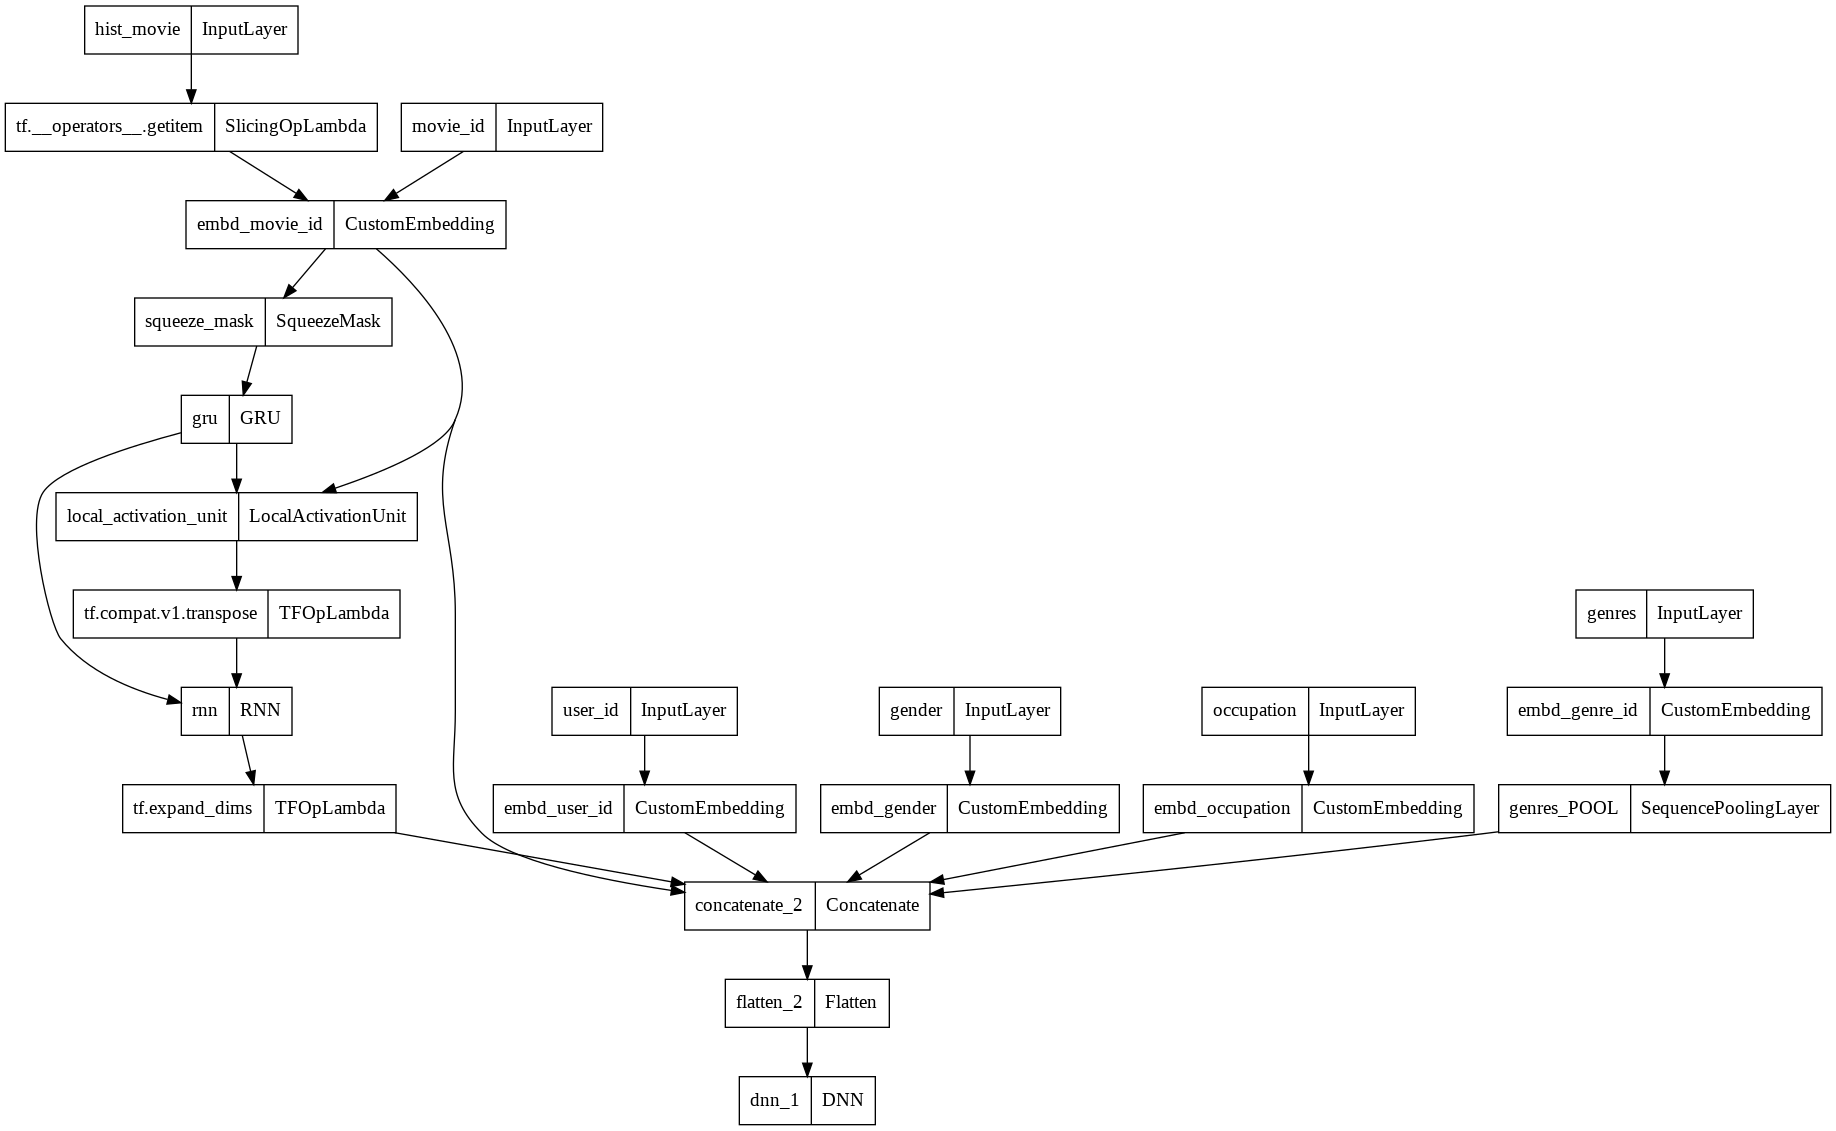

In [37]:
plot_model(model)

In [38]:
pred = model.predict(test_data, batch_size=BATCH_SIZE)

In [39]:
pred_df = pd.DataFrame(columns=['user_id','movie_id','pred'])
pred_df['user_id'] = test_data['user_id']
pred_df['movie_id'] = test_data['movie_id']
pred_df['pred'] = pred

pred_df = pred_df.sort_values(by=['user_id','pred'], ascending=False).reset_index(drop=True)
pred_df = pred_df.groupby('user_id')['movie_id'].apply(list).reset_index()

In [40]:
test_label_df = pd.DataFrame(columns=['user_id','label'])
test_label_df['user_id'] = pd.Series(test_data['user_id']).drop_duplicates()
test_label_df['label'] = test_label.tolist()

In [41]:
test_label_df = pd.merge(test_label_df, pred_df, on=['user_id'], how='left')

In [42]:
map_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.013424376053533575

In [43]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.036704372784062134

In [44]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=100)

0.13619787269964545